In [38]:
import logging
import os
import sys
from pathlib import Path
from typing import Tuple
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from vbase_utils.stats.pit_robust_betas import pit_robust_betas
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [39]:
import pandas as pd
etf_list = pd.read_csv("_____ETF___.csv")
etf_list = etf_list.drop_duplicates(subset='ETF Ticker', keep='first')
value_etf = etf_list[etf_list['스타일'] == "가치주 (Value)"].loc[:,'ETF Ticker'].to_list()
growth_etf = etf_list[etf_list['스타일'] == "성장주 (Growth)"].loc[:,'ETF Ticker'].to_list()
dividend_etf = etf_list[etf_list['스타일'] == "고배당 (High Dividend)"].loc[:,'ETF Ticker'].to_list()
small_etf = etf_list[etf_list['스타일'] == "소형주 (Small Cap)"].loc[:,'ETF Ticker'].to_list()
mid_etf = etf_list[etf_list['스타일'] == "중형주 (Mid Cap)"].loc[:,'ETF Ticker'].to_list()
large_etf = etf_list[etf_list['스타일'] == "대형주 (Large Cap)"].loc[:,'ETF Ticker'].to_list()
mid_etf.remove('IJH')
etf_assortment = [value_etf,growth_etf,dividend_etf,small_etf,mid_etf,large_etf]
etf_types = 'value_etf,growth_etf,dividend_etf,small_etf,mid_etf,large_etf'.split(',')

In [40]:
etf_list.groupby('스타일').count() # groupby "Style" (is translated to 스타일 in Korean)

,ETF Ticker
스타일,
가치주 (Value),17
고배당 (High Dividend),7
대형주 (Large Cap),5
모멘텀 (Momentum),1
성장주 (Growth),13
소형주 (Small Cap),8
스마트 베타,5
중형주 (Mid Cap),10


In [41]:
etf_assortment

[['RPV',
  'VOE',
  'VBR',
  'IWD',
  'IWS',
  'IWN',
  'IWX',
  'IUSV',
  'DTH',
  'EFV',
  'FDL',
  'FTA',
  'DON',
  'PID',
  'PFM',
  'PXF',
  'PWV'],
 ['RPG',
  'VUG',
  'VBK',
  'IVW',
  'IWO',
  'IWP',
  'IUSG',
  'SCHG',
  'SPYG',
  'EPS',
  'FAD',
  'FTC',
  'FTCS'],
 ['VYM', 'SDY', 'DHS', 'DVY', 'PEY', 'FVD', 'DEW'],
 ['IJS', 'PRFZ', 'RZV', 'RZG', 'FYX', 'DFE', 'DLS', 'DWX'],
 ['VOT', 'MDYV', 'MDYG', 'IJK', 'IJT', 'FNX', 'RWK', 'RFG', 'RFV'],
 ['SPHQ', 'IWF', 'DLN', 'DTD', 'FEX']]

In [42]:
etf_list['ETF Ticker'].unique()

array(['RPV', 'VOE', 'VBR', 'IWD', 'IWS', 'IWN', 'IWX', 'IUSV', 'DTH',
       'EFV', 'FDL', 'FTA', 'DON', 'PID', 'PFM', 'PXF', 'PWV', 'RPG',
       'VUG', 'VBK', 'IVW', 'IWO', 'IWP', 'IUSG', 'SCHG', 'SPYG', 'EPS',
       'FAD', 'FTC', 'FTCS', 'VYM', 'SDY', 'DHS', 'DVY', 'PEY', 'FVD',
       'DEW', 'IJS', 'PRFZ', 'RZV', 'RZG', 'FYX', 'DFE', 'DLS', 'DWX',
       'VOT', 'MDYV', 'MDYG', 'IJK', 'IJH', 'IJT', 'FNX', 'RWK', 'RFG',
       'RFV', 'SPHQ', 'IWF', 'DLN', 'DTD', 'FEX', 'PDP', 'RSP', 'PRN',
       'PTH', 'PWB', 'PUI'], dtype=object)

In [43]:
etf_list

,스타일,ETF Ticker
0,가치주 (Value),RPV
1,가치주 (Value),VOE
2,가치주 (Value),VBR
3,가치주 (Value),IWD
4,가치주 (Value),IWS
...,...,...
76,스마트 베타,RSP
81,스마트 베타,PRN
82,스마트 베타,PTH
83,스마트 베타,PWB


In [44]:
import yfinance as yf
irx = yf.download("^IRX", start="2010-01-01", end="2025-12-31")
irx = irx['Close']['^IRX']
rf_daily = ((1 + irx / 100) ** (1 / 252)) - 1
rf_daily.name = 'rf_daily'

/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_68707/99418034.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  irx = yf.download("^IRX", start="2010-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


In [45]:
def plot_cumulative_residuals(
    residuals: pd.DataFrame, title: str, figsize: Tuple[int, int] = (15, 8)
) -> None:
    """Plot cumulative residuals for a set of assets.

    Args:
        residuals: DataFrame of residuals to plot.
        title: Title for the plot.
        figsize: Figure size as (width, height).
    """
    cum_residuals = (1 + residuals).cumprod() - 1

    plt.figure(figsize=figsize)
    for col in cum_residuals.columns:
        plt.plot(cum_residuals.index, cum_residuals[col], label=col)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Residual Return")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [46]:
df_russel_rets = pd.read_csv("data/russel_etf_returns.csv",
    index_col=0,
    parse_dates=True,
)
df_rets = pd.read_csv(
                 "data/final_df_rets.csv",
    index_col=0,
    parse_dates=True,
)
df_rets.drop('ALTS', axis = 1, inplace = True)
weekly_rebalance_new = pd.DatetimeIndex([dt for dt in df_rets.index if dt.weekday() == 4])

In [47]:
cumul_etf = []
for i in etf_assortment:
    cumul_etf += i
# cumul_etf += ['XBI', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
df_rets[cumul_etf]


,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.009091,0.003110,-0.001081,0.005980,0.008258,-0.003693,0.014363,0.005222,0.003608,0.006376,...,0.001544,0.003428,0.004904,0.006750,0.004869,0.006167,0.000198,-0.000718,-0.001195,0.001708
2010-01-06,0.009009,0.007086,0.001623,0.003398,0.003699,-0.002022,0.000000,0.003247,-0.003146,0.002880,...,-0.002055,0.003796,0.007321,0.007040,0.013500,-0.001752,0.000000,0.000479,0.000000,0.004264
2010-01-07,0.015828,0.007256,0.008821,0.008464,0.007106,0.011818,0.016074,0.007380,-0.009465,-0.004020,...,0.004633,0.004917,0.004844,0.000998,0.007172,0.000877,0.000792,0.001676,0.003589,0.002123
2010-01-08,-0.000399,0.003274,0.003569,0.002350,0.004705,0.005507,-0.004896,0.002699,0.008646,0.010571,...,0.001879,0.003011,0.006830,0.007150,0.007121,0.001753,0.005539,0.001911,0.001193,0.004661
2010-01-11,0.003996,0.000870,-0.000534,0.002345,0.000780,-0.005643,0.007570,0.002435,0.008346,0.005516,...,-0.001534,0.002251,-0.001596,-0.004128,0.000674,-0.000875,-0.001771,0.004292,0.003810,0.001687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.006240,-0.008168,-0.009559,-0.008248,-0.009810,-0.009857,-0.007030,-0.008945,-0.009214,-0.012910,...,-0.007787,-0.008242,-0.011228,-0.007495,-0.008456,-0.008230,-0.008850,-0.007185,-0.006277,-0.008200
2025-06-18,0.000758,0.001300,0.004166,0.001907,0.003666,0.005436,0.000977,0.000979,0.002595,0.003391,...,0.002953,0.003217,0.002025,0.002517,-0.003345,-0.008585,-0.001353,0.000374,0.000387,0.002067
2025-06-20,0.004111,0.001793,0.001681,0.001533,0.001710,-0.002085,0.001707,0.002173,-0.007334,-0.007564,...,-0.000620,0.001425,0.002021,0.001674,0.001426,-0.001010,-0.006946,0.000998,0.000644,0.001969


In [48]:
market_returns = df_rets[['IWV']]
asset_returns_new = df_rets.drop("IWV", axis=1)

In [49]:
asset_returns_new

,AFK,AIVI,AIVL,BMVP,CSD,CSM,CZA,DBC,DBE,DBO,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002067,-0.004908,-0.001446,0.001289,0.004199,0.004521,0.003370,0.001189,0.000000,0.009256,...,0.003853,0.003234,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.014781,0.000673,0.002173,0.001546,0.003660,0.001566,0.001679,0.017808,0.014590,0.012346,...,0.013343,0.016994,0.011975,0.002005,0.002111,-0.011188,-0.000749,0.005861,0.010224,0.001328
2010-01-07,-0.000677,-0.010307,0.000482,0.001286,0.003125,0.003908,0.000838,-0.012442,-0.004056,-0.006969,...,0.000000,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.001695,0.012904,0.000963,0.001027,-0.001558,-0.000973,-0.000419,-0.000787,0.000370,0.004912,...,0.004509,0.013937,0.006509,-0.005879,0.015978,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,0.008799,0.002459,0.006256,0.001796,0.007800,0.006234,0.005027,-0.003152,-0.010363,-0.005587,...,0.005387,-0.005441,-0.001326,0.000657,0.010941,-0.003906,0.002635,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.011729,-0.012120,-0.005673,-0.005640,-0.011448,-0.010759,-0.009912,0.021239,0.036004,0.035236,...,-0.015233,-0.009759,0.009335,-0.005739,-0.007519,-0.007077,-0.008495,-0.008269,-0.016506,-0.017241
2025-06-18,0.007740,0.003327,0.000272,-0.002311,0.004483,0.000441,0.000385,0.002600,0.003426,0.001362,...,0.006821,-0.002865,-0.006542,-0.000398,-0.002385,0.001202,-0.001242,0.002614,-0.001723,0.000475
2025-06-20,-0.002048,-0.010570,0.002716,0.001895,0.000992,-0.001322,0.001155,0.005186,0.007317,0.005438,...,-0.003387,-0.006781,0.010218,0.002788,0.001125,-0.004429,0.007336,0.002731,-0.004803,0.001188


In [50]:
market_residuals = pd.read_csv("/Users/yunhojeon/Desktop/validity base/git/data/final_market residual(style+sector).csv",
                                   index_col=0,
                                parse_dates=True)
market_residuals

,AFK,AIVI,AIVL,ALTS,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.007671,0.001828,-0.001208,-0.000751,-0.003501,0.005239,-0.000100,-0.002027,-0.003720,-0.006045,...,-0.005100,-0.007080,-0.001302,0.000703,-0.000855,-0.000670,0.001511,0.000318,-0.004976,-0.002673
2010-04-13,-0.014826,0.000912,-0.000457,0.034483,0.002721,0.000000,0.001283,0.005057,0.003713,0.001129,...,-0.000164,-0.003736,-0.003502,0.000602,0.001570,0.002975,-0.003200,-0.005277,0.000937,0.005299
2010-04-14,-0.007447,-0.004004,-0.006209,0.050194,-0.000471,-0.004152,0.000368,0.004302,-0.000589,-0.000743,...,-0.001762,-0.008913,-0.005677,0.011129,0.000080,0.002708,-0.005669,-0.008730,-0.012504,0.004352
2010-04-15,0.002081,-0.002545,0.002784,0.024999,0.003363,0.006262,0.001948,0.001820,0.002435,0.000413,...,-0.003920,-0.001658,-0.001703,-0.005595,0.008305,0.003413,-0.002498,-0.001314,-0.003736,0.003197
2010-04-16,0.001471,0.005506,0.002059,-0.023942,0.002487,-0.003767,-0.004218,0.010348,-0.003436,-0.000326,...,0.007533,0.002877,0.001682,-0.018499,-0.000641,0.000988,0.004390,0.000286,0.005110,0.000439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.005216,-0.007050,0.001195,-0.120456,0.001107,-0.000581,-0.001508,-0.002294,0.023831,0.039302,...,-0.005077,-0.001416,0.016478,0.002187,0.000947,0.005160,-0.004663,-0.004374,-0.011544,-0.005952
2025-06-18,0.007596,0.003215,0.000120,0.110057,-0.002460,0.004243,0.000237,0.000217,0.002542,0.003353,...,0.006597,-0.003049,-0.006700,-0.000573,-0.002572,0.000931,-0.001326,0.002528,-0.001833,0.000226
2025-06-20,-0.000754,-0.009563,0.004080,0.036053,0.003236,0.003151,0.000516,0.002668,0.005701,0.007972,...,-0.001369,-0.005123,0.011637,0.004363,0.002807,-0.001997,0.008097,0.003505,-0.003818,0.003431


/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_68707/1135877734.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


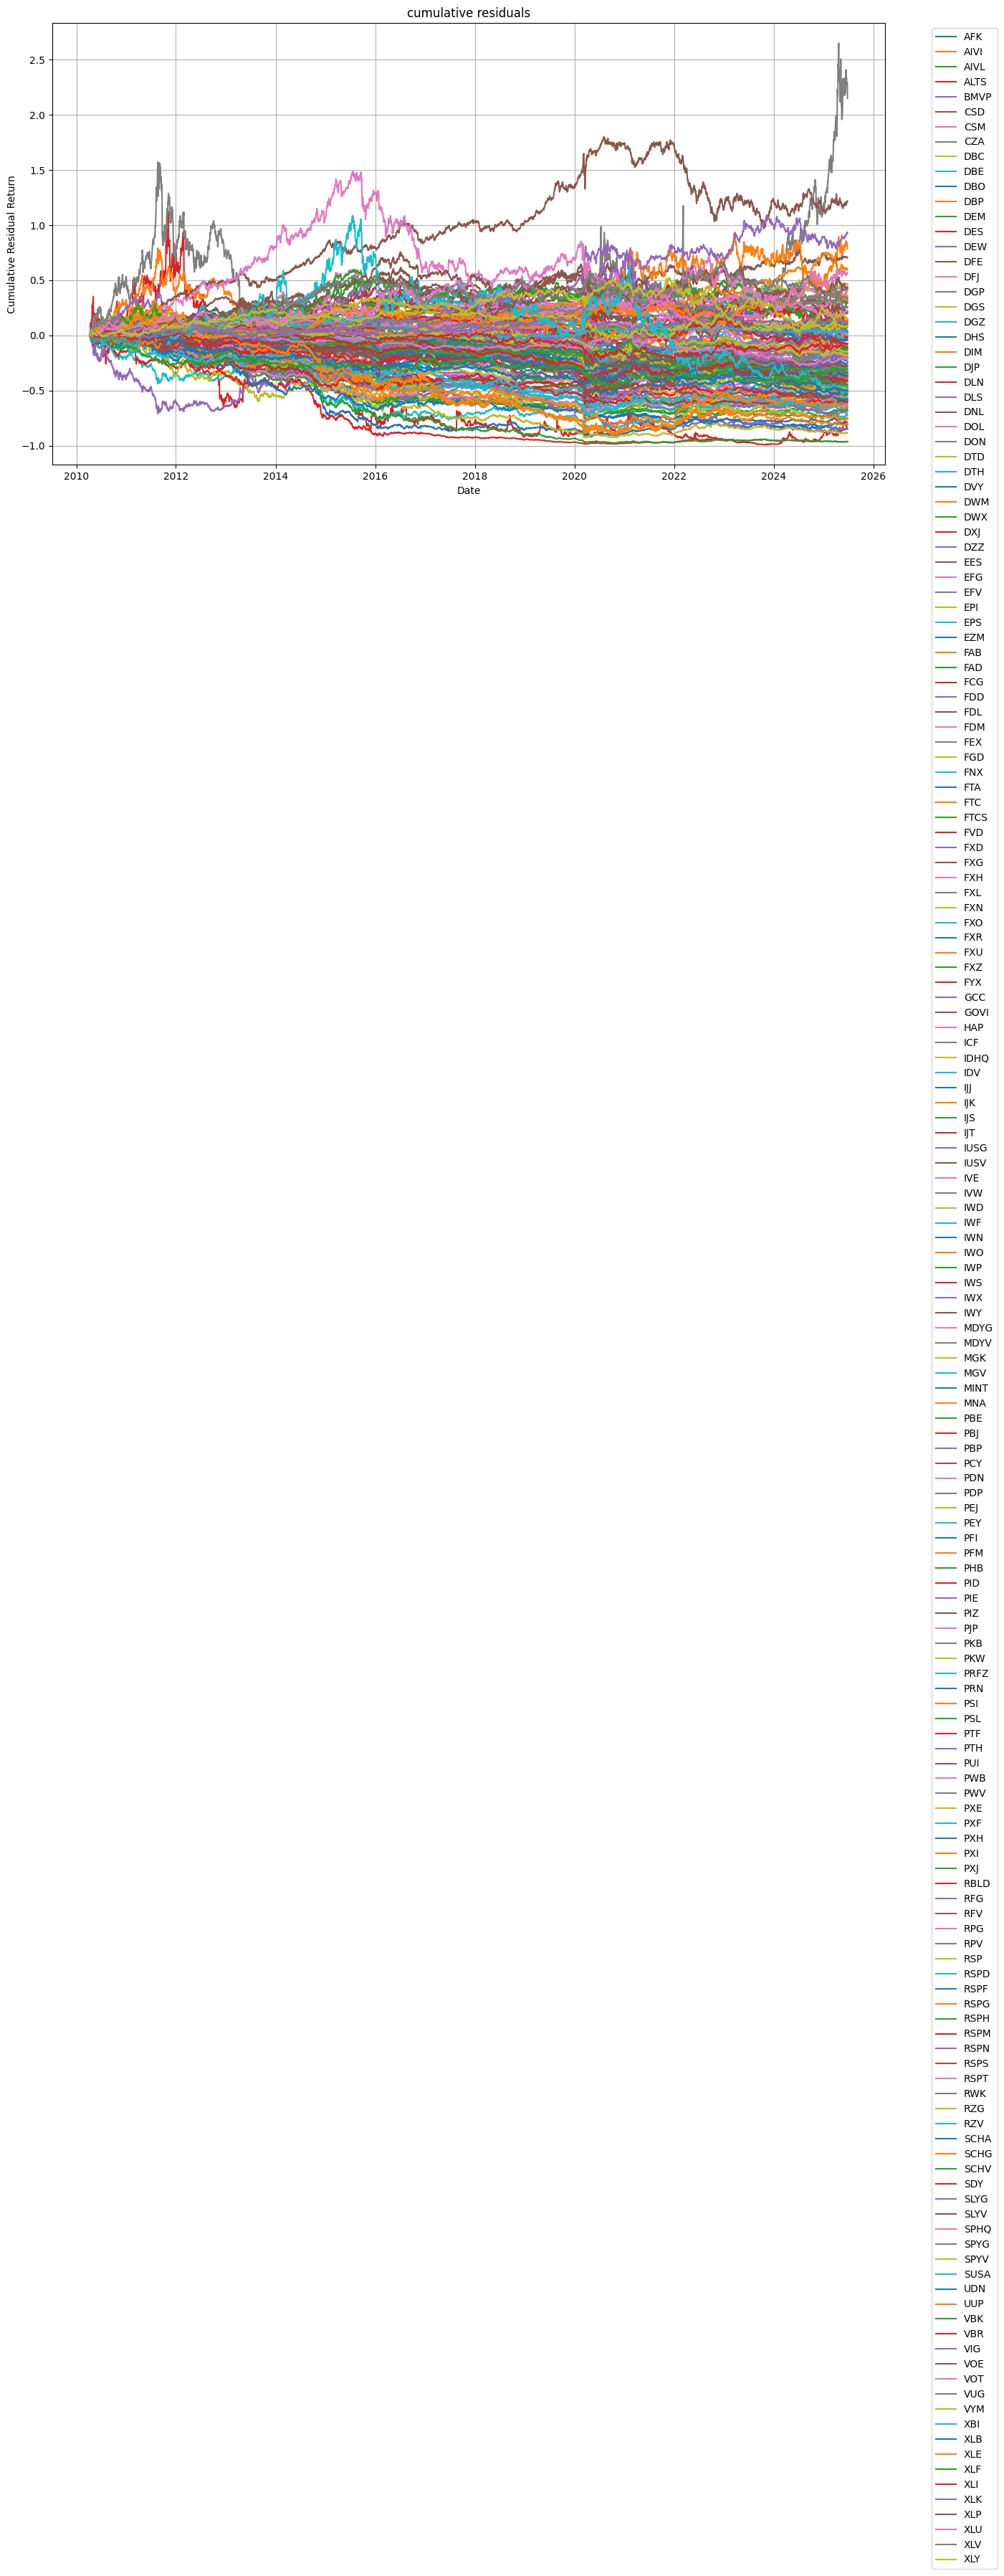

In [51]:
plot_cumulative_residuals(market_residuals, "cumulative residuals")

In [52]:
market_residuals

,AFK,AIVI,AIVL,ALTS,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.007671,0.001828,-0.001208,-0.000751,-0.003501,0.005239,-0.000100,-0.002027,-0.003720,-0.006045,...,-0.005100,-0.007080,-0.001302,0.000703,-0.000855,-0.000670,0.001511,0.000318,-0.004976,-0.002673
2010-04-13,-0.014826,0.000912,-0.000457,0.034483,0.002721,0.000000,0.001283,0.005057,0.003713,0.001129,...,-0.000164,-0.003736,-0.003502,0.000602,0.001570,0.002975,-0.003200,-0.005277,0.000937,0.005299
2010-04-14,-0.007447,-0.004004,-0.006209,0.050194,-0.000471,-0.004152,0.000368,0.004302,-0.000589,-0.000743,...,-0.001762,-0.008913,-0.005677,0.011129,0.000080,0.002708,-0.005669,-0.008730,-0.012504,0.004352
2010-04-15,0.002081,-0.002545,0.002784,0.024999,0.003363,0.006262,0.001948,0.001820,0.002435,0.000413,...,-0.003920,-0.001658,-0.001703,-0.005595,0.008305,0.003413,-0.002498,-0.001314,-0.003736,0.003197
2010-04-16,0.001471,0.005506,0.002059,-0.023942,0.002487,-0.003767,-0.004218,0.010348,-0.003436,-0.000326,...,0.007533,0.002877,0.001682,-0.018499,-0.000641,0.000988,0.004390,0.000286,0.005110,0.000439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.005216,-0.007050,0.001195,-0.120456,0.001107,-0.000581,-0.001508,-0.002294,0.023831,0.039302,...,-0.005077,-0.001416,0.016478,0.002187,0.000947,0.005160,-0.004663,-0.004374,-0.011544,-0.005952
2025-06-18,0.007596,0.003215,0.000120,0.110057,-0.002460,0.004243,0.000237,0.000217,0.002542,0.003353,...,0.006597,-0.003049,-0.006700,-0.000573,-0.002572,0.000931,-0.001326,0.002528,-0.001833,0.000226
2025-06-20,-0.000754,-0.009563,0.004080,0.036053,0.003236,0.003151,0.000516,0.002668,0.005701,0.007972,...,-0.001369,-0.005123,0.011637,0.004363,0.002807,-0.001997,0.008097,0.003505,-0.003818,0.003431


In [53]:
def compute_mean_acf(df, lags=[1, 5, 21, 42 , 63]):
    acf_values = {lag: [] for lag in lags}

    for col in df.columns:
        series = df[col].dropna()
        acfs = sm.tsa.acf(series, nlags=max(lags), fft=True)
        for lag in lags:
            acf_values[lag].append(acfs[lag])

    mean_acfs = {lag: sum(acf_values[lag]) / len(acf_values[lag]) for lag in lags}
    return pd.Series(mean_acfs, name="Mean ACF")

In [54]:
compute_mean_acf(market_residuals.loc[:"2019-01-01"])

1    -0.069834
5     0.004543
21   -0.006298
42   -0.004361
63   -0.000424
Name: Mean ACF, dtype: float64

In [55]:
df_rets

,IWV,AFK,AIVI,AIVL,BMVP,CSD,CSM,CZA,DBC,DBE,...,XBI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002561,0.002067,-0.004908,-0.001446,0.001289,0.004199,0.004521,0.003370,0.001189,0.000000,...,0.003853,0.003234,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.001954,0.014781,0.000673,0.002173,0.001546,0.003660,0.001566,0.001679,0.017808,0.014590,...,0.013343,0.016994,0.011975,0.002005,0.002111,-0.011188,-0.000749,0.005861,0.010224,0.001328
2010-01-07,0.003449,-0.000677,-0.010307,0.000482,0.001286,0.003125,0.003908,0.000838,-0.012442,-0.004056,...,0.000000,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.003587,0.001695,0.012904,0.000963,0.001027,-0.001558,-0.000973,-0.000419,-0.000787,0.000370,...,0.004509,0.013937,0.006509,-0.005879,0.015978,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,0.000893,0.008799,0.002459,0.006256,0.001796,0.007800,0.006234,0.005027,-0.003152,-0.010363,...,0.005387,-0.005441,-0.001326,0.000657,0.010941,-0.003906,0.002635,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.009362,-0.011729,-0.012120,-0.005673,-0.005640,-0.011448,-0.010759,-0.009912,0.021239,0.036004,...,-0.015233,-0.009759,0.009335,-0.005739,-0.007519,-0.007077,-0.008495,-0.008269,-0.016506,-0.017241
2025-06-18,0.000207,0.007740,0.003327,0.000272,-0.002311,0.004483,0.000441,0.000385,0.002600,0.003426,...,0.006821,-0.002865,-0.006542,-0.000398,-0.002385,0.001202,-0.001242,0.002614,-0.001723,0.000475
2025-06-20,-0.001860,-0.002048,-0.010570,0.002716,0.001895,0.000992,-0.001322,0.001155,0.005186,0.007317,...,-0.003387,-0.006781,0.010218,0.002788,0.001125,-0.004429,0.007336,0.002731,-0.004803,0.001188


In [56]:
df_rets_original = df_rets.copy()
market_residuals_original = market_residuals.copy()

In [57]:
market_residuals.columns

Index(['AFK', 'AIVI', 'AIVL', 'ALTS', 'BMVP', 'CSD', 'CSM', 'CZA', 'DBC',
       'DBE',
       ...
       'XBI', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'],
      dtype='object', length=169)

In [58]:
df_rets = df_rets[cumul_etf]
market_residuals = market_residuals[cumul_etf]

In [59]:
market_returns

,IWV
Date,
2010-01-05,0.002561
2010-01-06,0.001954
2010-01-07,0.003449
2010-01-08,0.003587
2010-01-11,0.000893
...,...
2025-06-17,-0.009362
2025-06-18,0.000207
2025-06-20,-0.001860


In [60]:
market_residuals

,RPV,VOE,VBR,IWD,IWS,IWN,IWX,IUSV,DTH,EFV,...,IJT,FNX,RWK,RFG,RFV,SPHQ,IWF,DLN,DTD,FEX
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12,0.000836,-0.001229,-0.000872,0.000410,-0.002238,0.000049,0.000743,-0.000804,-0.001189,0.002569,...,0.001115,-0.001355,-0.000666,-0.001817,-0.002278,-0.004633,-0.001693,-0.000909,-0.000730,-0.001512
2010-04-13,-0.003991,0.000597,0.004468,0.000476,0.000954,0.003741,-0.000362,0.000363,-0.000694,-0.001531,...,0.002691,0.003747,0.003686,0.003619,0.001512,0.004959,0.001891,0.001151,0.001598,0.001182
2010-04-14,0.003508,-0.001134,0.004917,0.000877,-0.000030,0.006498,0.006604,0.001528,-0.004516,-0.002934,...,0.007879,0.003839,0.003670,-0.001341,0.005651,0.003163,-0.002532,-0.006172,-0.003169,-0.003466
2010-04-15,-0.005996,-0.003129,0.000023,-0.002555,-0.004977,0.001923,0.000312,-0.000953,-0.002035,-0.000191,...,0.001905,0.000043,-0.000651,-0.000939,0.002079,0.004409,0.002068,0.000080,-0.001985,-0.000135
2010-04-16,-0.006488,-0.000867,0.002374,-0.003946,0.001006,0.001950,-0.011497,-0.004035,0.001916,-0.002654,...,0.006357,0.003962,0.005423,0.005643,0.000117,0.006370,0.000972,0.001446,0.001515,0.001369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.001083,-0.000743,-0.000554,-0.000769,-0.001394,-0.000618,-0.000489,-0.001507,-0.003952,-0.006877,...,0.002049,0.001336,-0.001626,0.003036,0.001653,0.000038,0.002164,-0.000516,0.000548,0.000206
2025-06-18,0.000596,0.001136,0.003967,0.001742,0.003481,0.005232,0.000832,0.000814,0.002479,0.003258,...,0.002736,0.003005,0.001813,0.002285,-0.003568,-0.008767,-0.001596,0.000227,0.000236,0.001881
2025-06-20,0.005566,0.003269,0.003470,0.003019,0.003382,-0.000249,0.003007,0.003651,-0.006288,-0.006365,...,0.001335,0.003328,0.003928,0.003767,0.003435,0.000633,-0.004758,0.002323,0.002000,0.003639


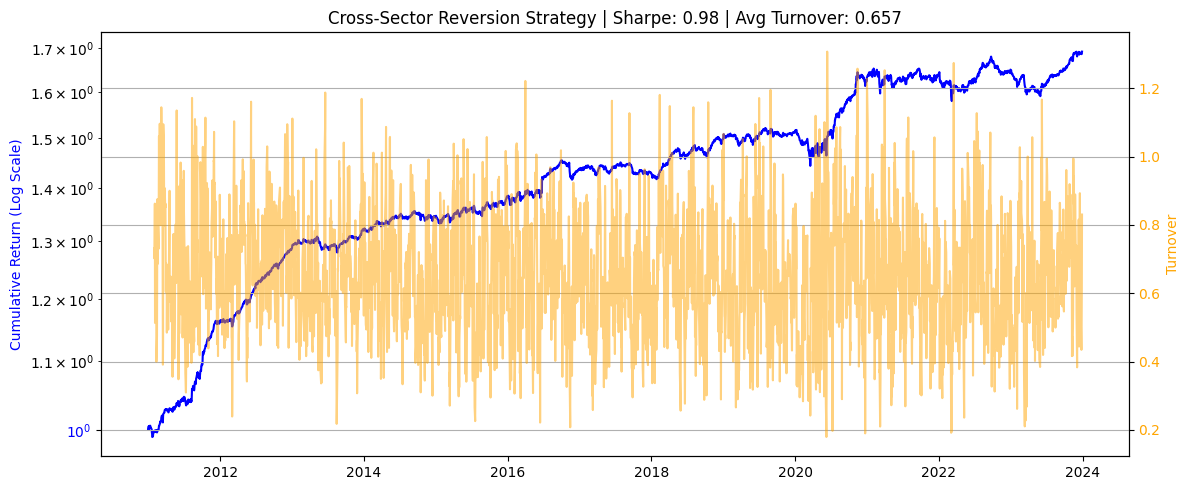

In [61]:
def backtest(df_rets, market_residuals, market_returns, etf_assortment, rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True,
              exponential_weights = True, sector_neutral = True, percentile = True, market_hedged = False, beta_window = 60, weights_clip = False, max_weight = 0.05):
    
    
    sector_resid = market_residuals
    if vol_scale:
        vol = sector_resid.rolling(vol_window).std().dropna()
        scaled_sector_resid = sector_resid / (vol + 1e-6)
        cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    else:
        cumulative_resid = (1+sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
        daily_reverse_signal = - cumulative_resid
    
    z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    if sector_neutral:
        for etfs in etf_assortment:
            z = z_scores_group[etfs]
            z_sector_adj = z.sub(z.mean(axis=1), axis=0)
            z_scores_group[etfs] = z_sector_adj
        z_all = z_scores_group
    else:
        z_all = z_scores_group
    if not percentile:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
        long_signals = z_scores.clip(lower=0)
        short_signals = z_scores.clip(upper=0)
        
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
        weights = long_weights + short_weights
        if exponential_weights:
            weights = weights.ewm(span=10, adjust=False).mean()

            long_weights = weights.clip(lower=0)
            short_weights = weights.clip(upper=0)

            long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
            short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

            weights = long_weights + short_weights
    else:
        z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
                  .div(z_all.std(axis=1), axis=0))

        quantile = 0.1
        top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
        bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

        long_signals = z_scores.where(top_mask, 0)
        short_signals = z_scores.where(bottom_mask, 0)
        long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights

    if weights_clip:
        max_change = max_weight 

        weights_clipped = weights.copy()
        for t in range(1, len(weights)):
            delta = weights.iloc[t] - weights_clipped.iloc[t - 1]
            delta = delta.clip(lower=-max_change, upper=max_change)
            weights_clipped.iloc[t] = weights_clipped.iloc[t - 1] + delta
        weights = weights_clipped
        long_weights = weights.clip(lower=0)
        short_weights = weights.clip(upper=0)

        long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
        short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

        weights = long_weights + short_weights
    df_rets.index = pd.to_datetime(df_rets.index)
    weights.index = pd.to_datetime(weights.index)
    if vol_scale:
        common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    else:
        common_dates = weights.index.intersection(df_rets.index)
    weights = weights.loc[common_dates]
    df_rets = df_rets.loc[common_dates]
    
    turnover = pd.Series(index=weights.index, dtype=float)



    # avg_turnover = compute_turnover_accurate(weights, df_rets)

    turnover = pd.Series(index=weights.index, dtype=float)

    for t in range(vol_window, len(weights)):
        prev = weights.iloc[t - 1]
        curr = weights.iloc[t]
        turnover.iloc[t] = (curr - prev).abs().sum()

    avg_turnover = turnover.dropna().mean()
    strategy_returns = (weights.shift(1) * df_rets).sum(axis=1)
    if not market_hedged:
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)
    else:
        window = beta_window
        aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
        aligned.columns = ['strategy', 'market']
        rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
        hedged_returns = aligned['strategy'] - rolling_beta * aligned['market']
        strategy_returns = hedged_returns
        same_date = strategy_returns.index.intersection(rf_daily.index)
        sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)


    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()
        
    if plot_true:
        cum_returns = (1 + strategy_returns).cumprod()
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(cum_returns, color='blue', label='Cumulative Return')
        ax1.set_ylabel('Cumulative Return (Log Scale)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale("log")

        ax2 = ax1.twinx()
        ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
        ax2.set_ylabel('Turnover', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

        return (long_weights,short_weights,weights,strategy_returns)
    
(long_weights,short_weights,weights,strategy_returns) = backtest(market_residuals.loc['2010-12-31':'2023-12-31'], market_residuals.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60)


In [62]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,0.192299
market,0.192299,1.000000


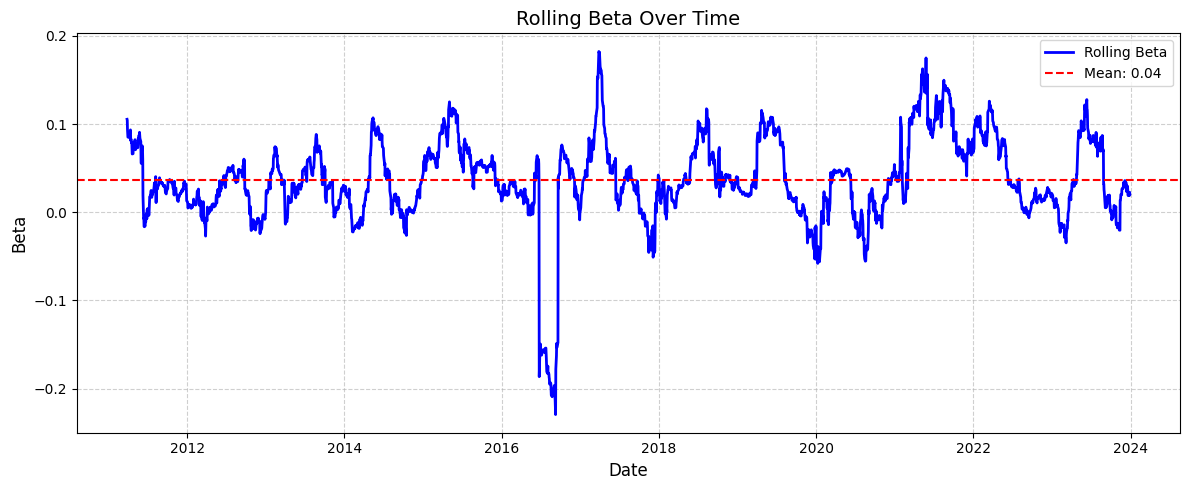

In [63]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

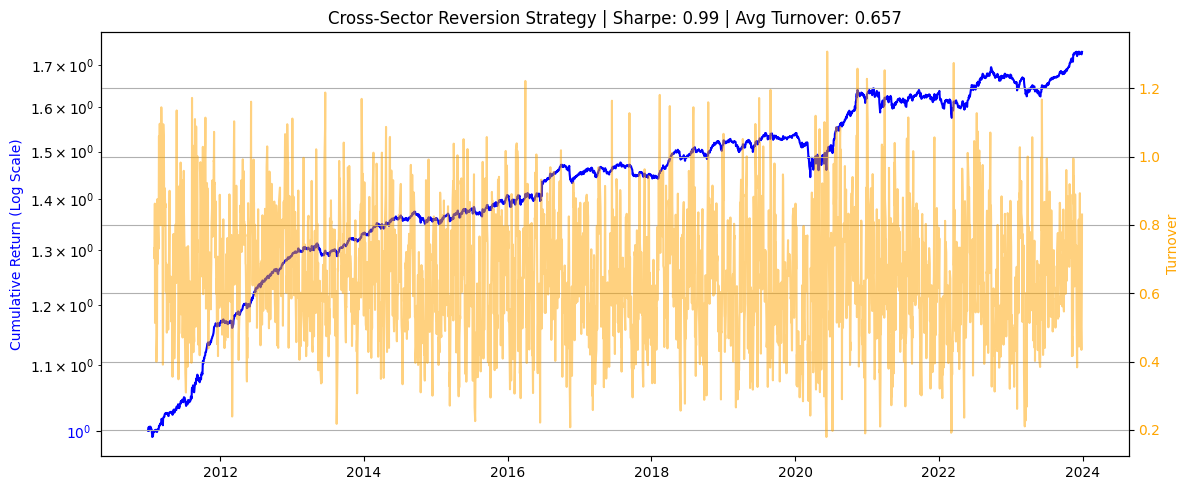

In [64]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], market_residuals.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60)

In [65]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.00000,0.21509
market,0.21509,1.00000


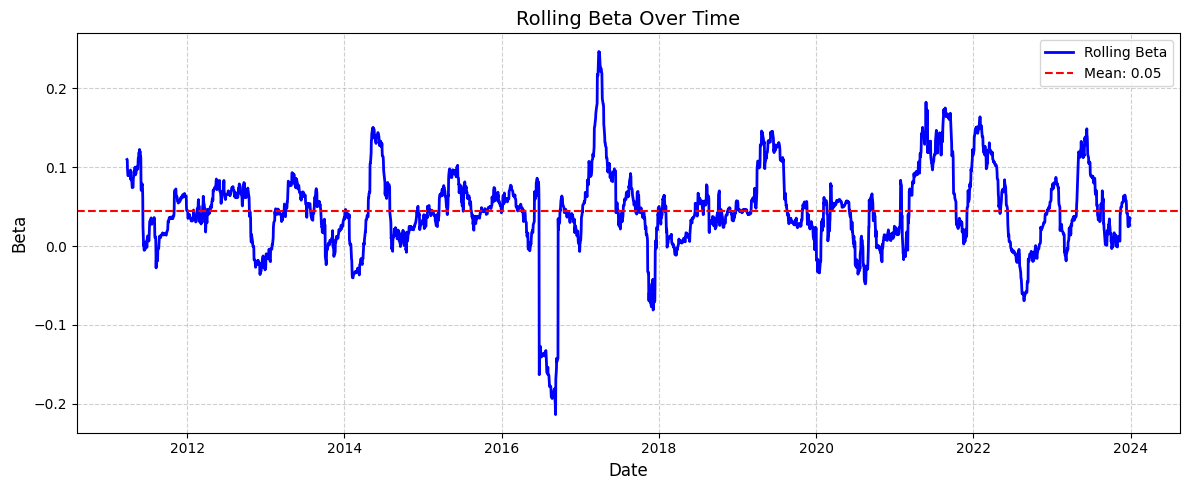

In [66]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

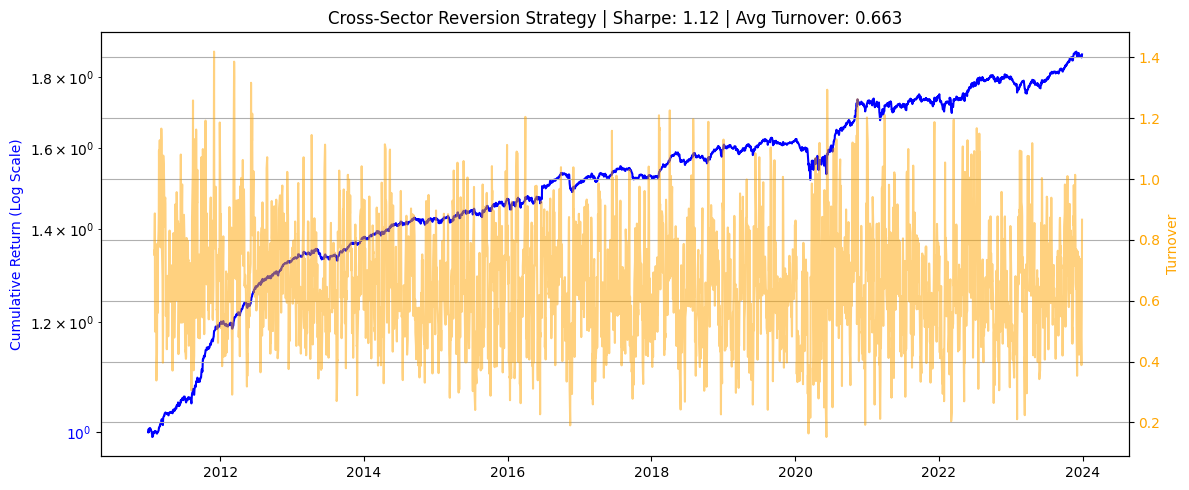

In [67]:
(long_weights,short_weights,weights,strategy_returns) = backtest(df_rets.loc['2010-12-31':'2023-12-31'], df_rets.loc['2010-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = False, plot_true = True, sector_neutral= True, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60)

In [68]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,0.230893
market,0.230893,1.000000


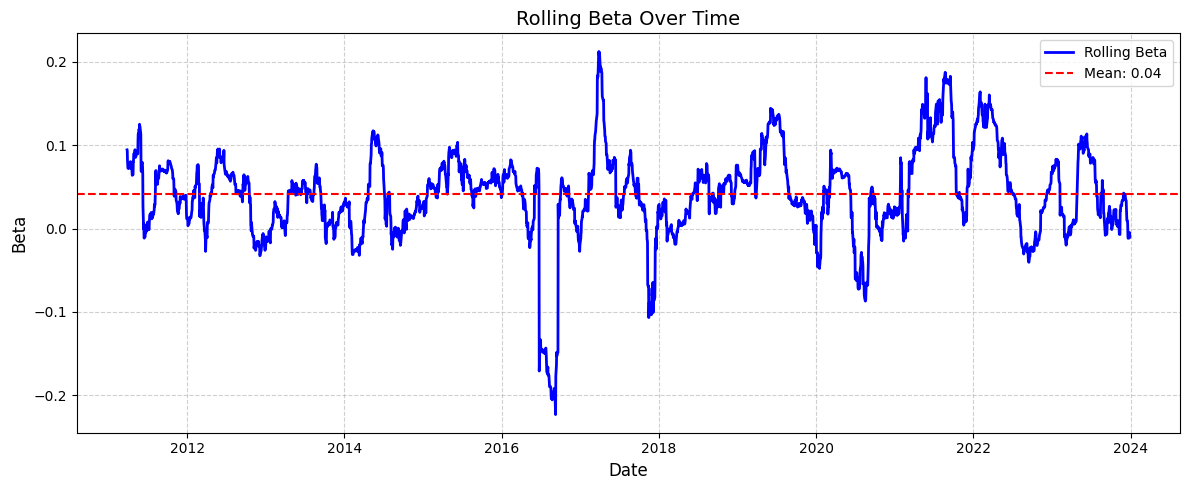

In [69]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [70]:
#def backtest2(df_rets, market_residuals, etf_assortment, rf_daily, long_window = 40, short_window = 5,vol_window = 100, vol_scale = False, plot_true = True,
    #           exponential_weights = True, sector_neutral = True, percentile = True):
    
    
    # sector_resid = market_residuals
    # if vol_scale:
    #     vol = sector_resid.rolling(vol_window).std().dropna()
    #     scaled_sector_resid = sector_resid / (vol + 1e-6)
    #     cumulative_resid = (1+scaled_sector_resid).rolling(window=signal_window).apply(np.prod, raw=True) - 1 
    #     daily_reverse_signal = - cumulative_resid
    # else:
    #     long_signals = (1+sector_resid).rolling(window=long_window).apply(np.prod, raw=True) - 1 
    #     cumulative_resid = long_signals
    #     daily_reverse_signal = cumulative_resid
    # # time sereis_operation is possible

    # #
    # z_scores_group = daily_reverse_signal.sub(cumulative_resid.mean(axis=1), axis = 0).div(cumulative_resid.std(axis=1), axis = 0)
    # # print(z_scores_group)
    # if sector_neutral:
    #     for etfs in etf_assortment:
    #         z = z_scores_group[etfs]
    #         z_sector_adj = z.sub(z.mean(axis=1), axis=0)
    #         z_scores_group[etfs] = z_sector_adj
    #     z_all = z_scores_group
    # else:
    #     z_all = z_scores_group
    # if not percentile:
    #     z_scores = (z_all.sub(z_all.mean(axis=1), axis  = 0).div(z_all.std(axis=1), axis = 0))
    #     long_signals = z_scores.clip(lower=0)
    #     short_signals = z_scores.clip(upper=0)
        
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2
    #     weights = long_weights + short_weights
    #     if exponential_weights:
    #         weights = weights.ewm(span=10, adjust=False).mean()

    #         long_weights = weights.clip(lower=0)
    #         short_weights = weights.clip(upper=0)

    #         long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0) * 1/2
    #         short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #         weights = long_weights + short_weights
    # else:
    #     z_scores = (z_all.sub(z_all.mean(axis=1), axis=0)
    #               .div(z_all.std(axis=1), axis=0))

    #     quantile = 0.1
    #     top_mask = z_scores.ge(z_scores.quantile(1 - quantile, axis=1), axis=0)
    #     bottom_mask = z_scores.le(z_scores.quantile(quantile, axis=1), axis=0)

    #     long_signals = z_scores.where(top_mask, 0)
    #     short_signals = z_scores.where(bottom_mask, 0)
    #     long_weights = long_signals.div(long_signals.sum(axis=1), axis=0).fillna(0) * 1/2
    #     short_weights = short_signals.div(short_signals.abs().sum(axis=1), axis=0).fillna(0) * 1/2

    #     weights = long_weights + short_weights



    # df_rets.index = pd.to_datetime(df_rets.index)
    # weights.index = pd.to_datetime(weights.index)
    # if vol_scale:
    #     common_dates = weights.index.intersection(df_rets.index).intersection(vol.index)
    # else:
    #     common_dates = weights.index.intersection(df_rets.index)
    # weights = weights.loc[common_dates]
    # df_rets = df_rets.loc[common_dates]
    
    # turnover = pd.Series(index=weights.index, dtype=float)

    # for t in range(vol_window, len(weights)):
    #     prev = weights.iloc[t - 1]
    #     curr = weights.iloc[t]
    #     turnover.iloc[t] = (curr - prev).abs().sum()

    # avg_turnover = turnover.dropna().mean()
    # strategy_returns = (weights.shift(1) * df_rets).sum(axis=1)
    # same_date = strategy_returns.index.intersection(rf_daily.index)
    # sharpe = ((strategy_returns[same_date] - rf_daily[same_date]).mean()) / strategy_returns.std() * np.sqrt(252)

    # if plot_true:
    #     cum_returns = (1 + strategy_returns).cumprod()
    #     fig, ax1 = plt.subplots(figsize=(12, 5))

    #     ax1.plot(cum_returns, color='blue', label='Cumulative Return')
    #     ax1.set_ylabel('Cumulative Return', color='blue')
    #     ax1.tick_params(axis='y', labelcolor='blue')

    #     ax2 = ax1.twinx()
    #     ax2.plot(turnover, color='orange', alpha=0.5, label='Turnover')
    #     ax2.set_ylabel('Turnover', color='orange')
    #     ax2.tick_params(axis='y', labelcolor='orange')

    #     plt.title(f'Cross-Sector Reversion Strategy | Sharpe: {sharpe:.2f} | Avg Turnover: {avg_turnover:.3f}')
    #     fig.tight_layout()
    #     plt.grid(True)
    #     plt.show()

    #     return weights 

In [71]:
russel = pd.read_csv("russel 2000.csv")
russel = russel[1:]
russel.columns = ['Date'] + list(russel.columns[1:])
russel['Date'] = pd.to_datetime(russel['Date'])
russel.set_index("Date",inplace=True)
russel = russel.apply(pd.to_numeric, errors='coerce')
non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float)))
non_numeric_cols = non_numeric_mask.any()
print(non_numeric_cols[non_numeric_cols].index.tolist())
non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float, np.integer, np.floating)))
non_numeric_positions = non_numeric_mask[non_numeric_mask]
for row_idx, col in non_numeric_positions.stack().index:
    val = russel.loc[row_idx, col]

/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_68707/3456777712.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

[]


/var/folders/6x/xp45m8ws0zj3yl7vwtwgbs8c0000gn/T/ipykernel_68707/3456777712.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_mask = ~russel.applymap(lambda x: isinstance(x, (int, float, np.integer, np.floating)))


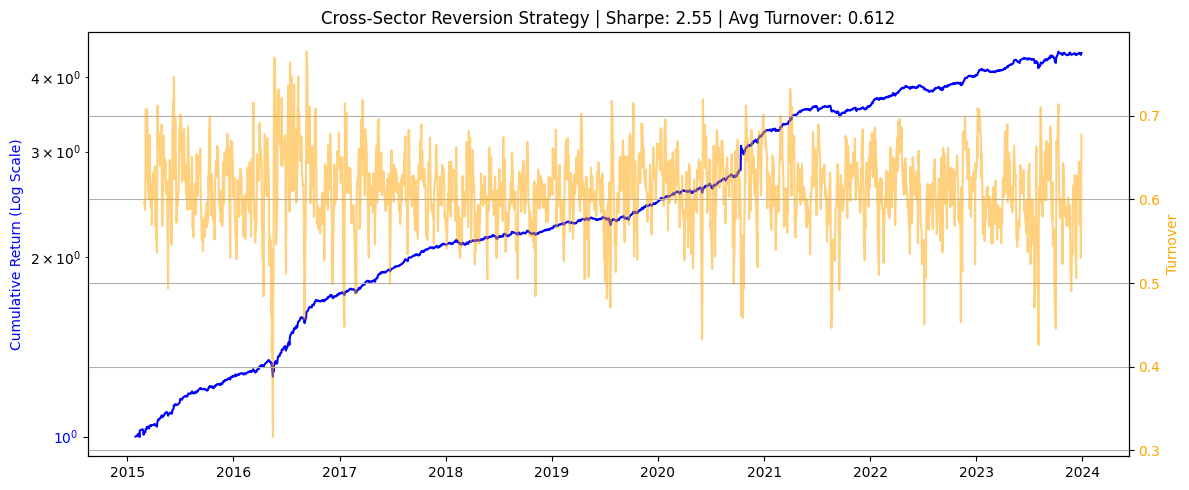

In [72]:
(long_weights,short_weights,weights,strategy_returns) = backtest(russel.loc['2014-12-31':'2023-12-31'], russel.loc['2014-12-31':'2023-12-31'],market_returns, etf_assortment,
          rf_daily, signal_window = 1, vol_window = 20, vol_scale = True, plot_true = True, sector_neutral= False, exponential_weights= True, percentile = False, market_hedged = False,
          beta_window= 60)

In [73]:
window = 60
aligned = pd.concat([strategy_returns, market_returns['IWV']], axis=1).dropna()
aligned.columns = ['strategy', 'market']
rolling_beta = aligned['strategy'].rolling(window).cov(aligned['market']) / aligned['market'].rolling(window).var()
aligned = aligned.iloc[1:]
aligned.corr()

,strategy,market
strategy,1.000000,-0.022855
market,-0.022855,1.000000


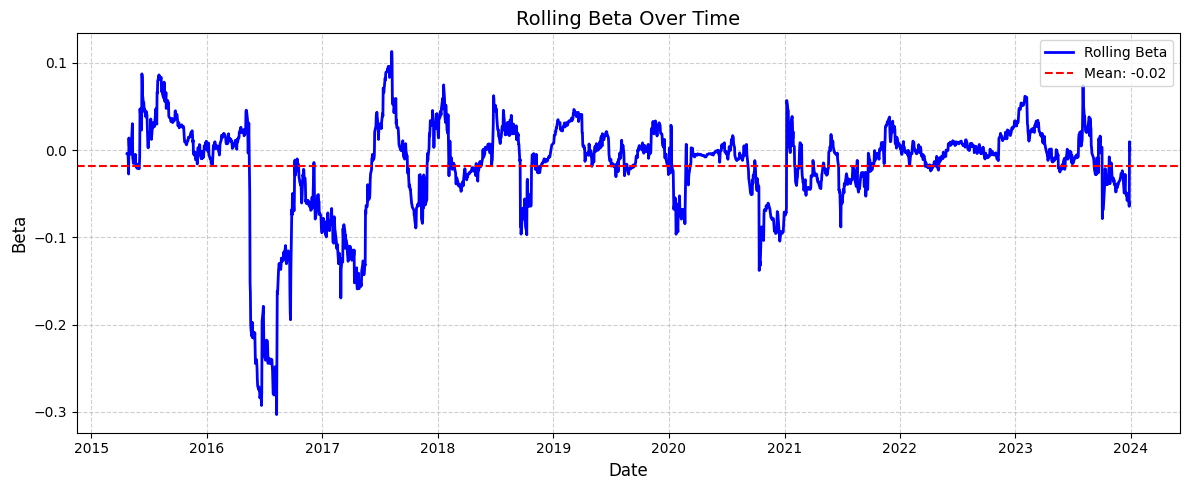

In [74]:
mean_beta = rolling_beta.mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_beta, label='Rolling Beta', color='blue', linewidth=2)
plt.axhline(mean_beta, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_beta:.2f}')

plt.title('Rolling Beta Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()